# Analysis of ATP data

In [288]:
import sqlite3
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from ipywidgets import VBox


#from sklearn.preprocessing import LabelEncoder, MinMaxScaler
#from sklearn.model_selection import train_test_split


### Comparison of winrates per year  
To start with, we want to give a look at how the players' winrate changed over the years and compare them. We take into consideration all the matches that were played.

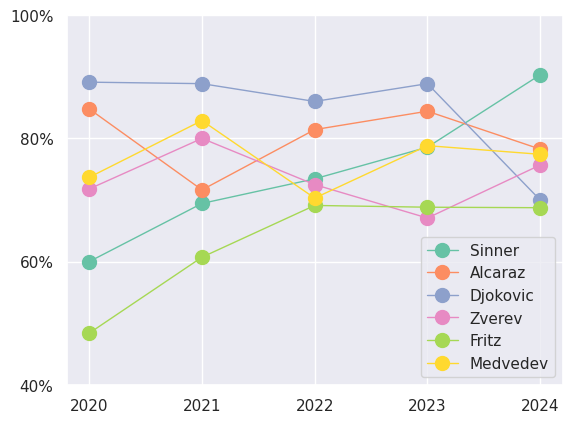

In [289]:
years = [2020, 2021, 2022, 2023, 2024]
players = ["sinner", "alcaraz", "djokovic", "zverev", "fritz", "medvedev"]

# Connect to the db
conn = sqlite3.connect("../data.db")
cur = conn.cursor()

sns.set_theme(palette="Set2")

for name in players:
    wr = []
    for y in years:
        cmd = "SELECT COUNT(*) FROM " + name + " WHERE win='yes' and tourney_date LIKE '" + str(y) + "%';" # count wins
        cur.execute(cmd)
        w = cur.fetchone()[0]
        cmd = "SELECT COUNT(*) FROM " + name + " WHERE win='no' and tourney_date LIKE '" + str(y) + "%';" # count losses
        cur.execute(cmd)
        l = cur.fetchone()[0]
        wr.append(w/(w+l) * 100)
    plt.plot(years, wr, 'o-', label=name.title(), markersize=10, linewidth=1.0)

plt.legend()
#plt.grid()
ax = plt.gca()
ax.set_xticks(years)
ax.set_yticks([40, 60, 80, 100])
ax.set_yticklabels(str(s) + "%" for s in [40, 60, 80, 100])
plt.savefig("./figures/winrate_per_year.png")
plt.show()

### Comparison of winrates on each court including years 2023 and 2024

SELECT COUNT(*) FROM sinner WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM alcaraz WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM djokovic WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM zverev WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM fritz WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';
SELECT COUNT(*) FROM medvedev WHERE win='yes' AND (tourney_date LIKE '2022%' OR tourney_date LIKE '2023%' OR tourney_date LIKE '2024%') AND surface='Hard';


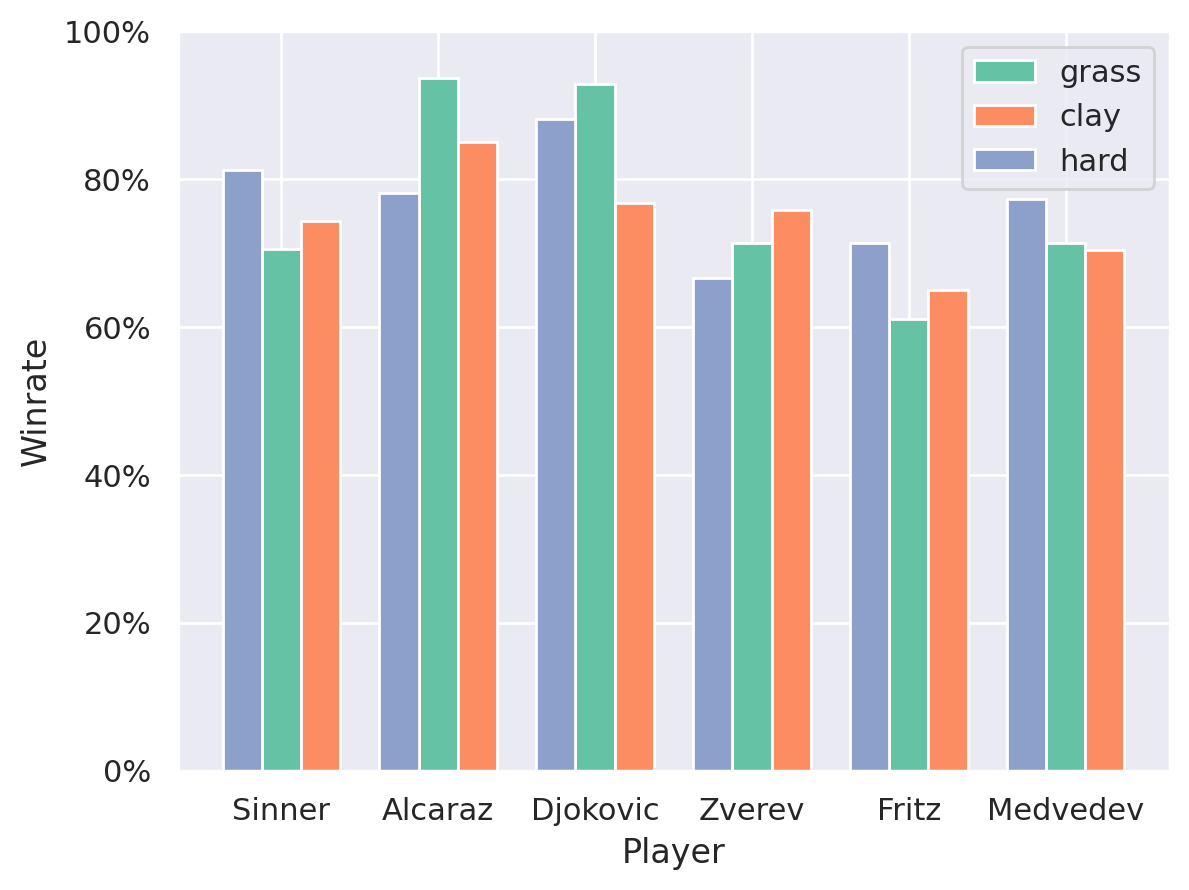

In [ ]:

players = ["sinner", "alcaraz", "djokovic", "zverev", "fritz", "medvedev"]
years = [2022, 2023, 2024]
barWidth = 0.25

fig, ax = plt.subplots(dpi=200)

sns.set_theme(palette="Set2")


wr_hard = []
wr_grass = []
wr_clay = []
for name in players:

    year_query = "("
    for y in years:
        year_query += f"tourney_date LIKE '{y}%' OR "
    year_query = year_query[:-4]
    year_query += ") "

    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='yes' AND " + \
            year_query + "AND surface='Hard';"
    print(cmd)
    cur.execute(cmd)
    w = cur.fetchone()[0]
    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='no' AND " + \
            year_query + "AND surface='Hard';"
    cur.execute(cmd)
    l = cur.fetchone()[0]
    wr_hard.append(w / (w+l) * 100)

    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='yes' AND " + \
            year_query + "AND surface='Grass';"
    cur.execute(cmd)
    w = cur.fetchone()[0]
    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='no' AND " + \
        year_query + "AND surface='Grass';"
    cur.execute(cmd)
    l = cur.fetchone()[0]
    wr_grass.append(w / (w+l) * 100)

    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='yes' AND " + \
        year_query + "AND surface='Clay';"
    cur.execute(cmd)
    w = cur.fetchone()[0]
    cmd = f"SELECT COUNT(*) FROM {name} WHERE win='no' AND " + \
        year_query + "AND surface='Clay';"
    cur.execute(cmd)
    l = cur.fetchone()[0]
    wr_clay.append(w / (w+l) * 100)

r = np.arange(len(wr_hard))
r2 = r + barWidth
r3 = r2 + barWidth

ax.bar(r2, wr_grass, width=barWidth, edgecolor='white', label='Grass')
ax.bar(r3, wr_clay, width=barWidth, edgecolor='white', label='Clay')
ax.bar(r, wr_hard, width=barWidth, edgecolor='white', label='Hard')

ax.set_xticks(r + barWidth)
ax.set_xticklabels([p.title() for p in players])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(str(s) + "%" for s in [0, 20, 40, 60, 80, 100])

plt.xlabel("Player")
plt.ylabel("Winrate")

plt.legend()
plt.savefig("./figures/court_winrates.png")
plt.show()

### Number of aces

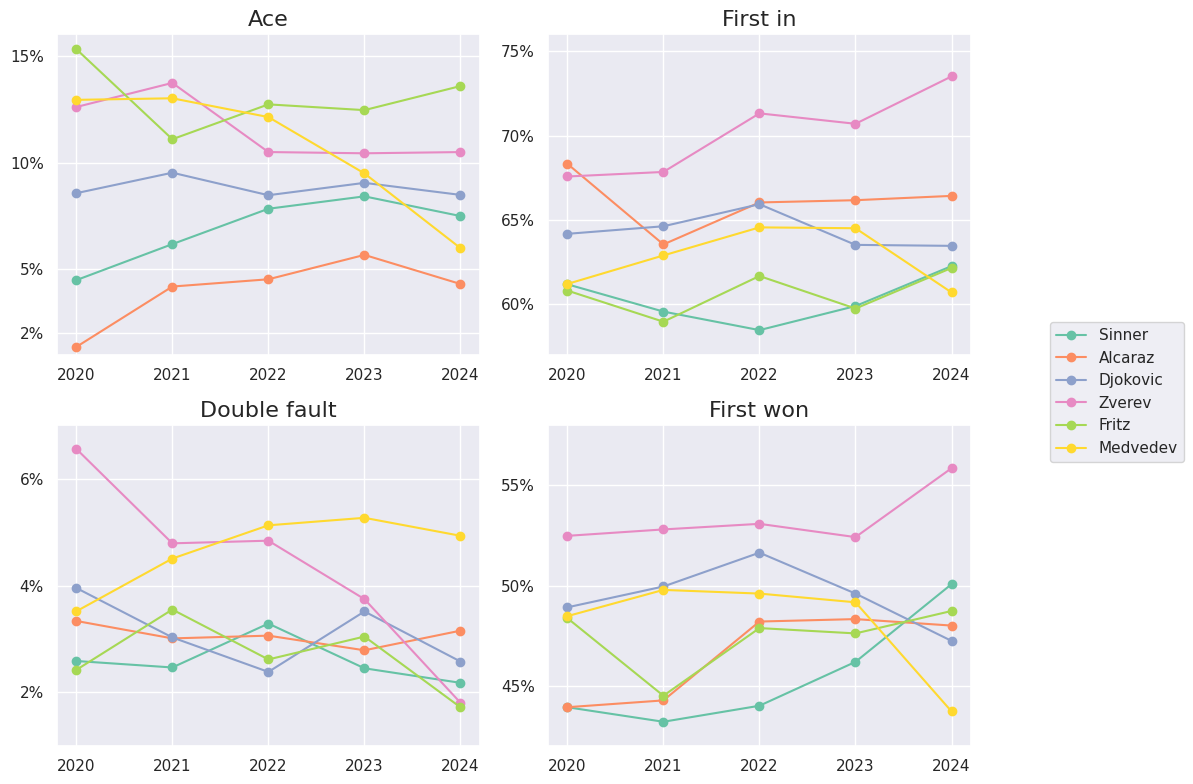

In [291]:
import time

years = [2020, 2021, 2022, 2023, 2024]
players = ["sinner", "alcaraz", "djokovic", "zverev", "fritz", "medvedev"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for name in players:
    ace_values, fin_values, df_values, fwon_values = [[] for _ in range(4)]

    for y in years:

        # Query database
        cmd = f"SELECT firstIn, df, firstWon, ace, serve_points FROM {name} WHERE tourney_date LIKE '%{y}%';"
        cur.execute(cmd)
        results = cur.fetchall()

        # Parse query results
        firstIn = [res[0] for res in results]
        df = [res[1] for res in results]
        firstWon = [res[2] for res in results]
        ace = [res[3] for res in results]
        serve_points = [res[4] for res in results]
        
        # Ace
        values = []
        for v1,v2 in zip(ace, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)
        ace_values.append(np.average(values))

        # First in
        values = []
        for v1,v2 in zip(firstIn, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)

        fin_values.append(np.average(values))

        # Double faults
        values = []
        for v1,v2 in zip(df, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)

        df_values.append(np.average(values))

        # First won
        values = []
        for v1,v2 in zip(firstWon, serve_points):
            if v1 is not None and v2 is not None:
                values.append(100 *  v1 / v2)
        fwon_values.append(np.average(values))

    axes[0,0].plot(years, ace_values, 'o-', label=f"{name}")
    axes[0,1].plot(years, fin_values, 'o-')
    axes[1,0].plot(years, df_values, 'o-')
    axes[1,1].plot(years, fwon_values, 'o-')

axes[0,0].set_yticks([2, 5, 10, 15])
axes[0,1].set_yticks([60, 65, 70, 75])
axes[1,0].set_yticks([2, 4, 6])
axes[1,1].set_yticks([45, 50, 55])

axes[0,0].set_yticklabels(["2%", "5%", "10%", "15%"])
axes[0,1].set_yticklabels(["60%", "65%", "70%", "75%"])
axes[1,0].set_yticklabels(["2%", "4%", "6%"])
axes[1,1].set_yticklabels(["45%", "50%", "55%"])

axes[0,0].set_xticks(years)
axes[0,1].set_xticks(years)
axes[1,0].set_xticks(years)
axes[1,1].set_xticks(years)

axes[0,0].set_ylim([1,16])
axes[0,1].set_ylim([57,76])
axes[1,0].set_ylim([1,7])
axes[1,1].set_ylim([42,58])

axes[0,0].set_title("Ace", fontsize=16)
axes[0,1].set_title("First in", fontsize=16)
axes[1,0].set_title("Double fault", fontsize=16)
axes[1,1].set_title("First won", fontsize=16)

axes[0,0].set_xticks(years)
axes[0,1].set_xticks(years)
axes[1,0].set_xticks(years)
axes[1,1].set_xticks(years)


handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, [name.title() for name in labels], loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
time.sleep(1)
plt.savefig("./figures/serve.png")


## Djokovic ML model  

In [292]:
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score
class Error:
    def __init__(self, f1, balanced, msq):
        self.f1 = f1
        self.balanced = balanced
        self.msq = msq
    def __str__(self):
        return f"F1 score: {self.f1} \nBalanced accuracy score: {self.balanced} \nAccuracy score: {self.msq}"

def compute_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    balanced = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    return Error(f1, balanced, acc)

### Load datataset and visualize it

In [293]:
df = pd.read_sql_query("SELECT * FROM djokovic ORDER BY win", conn) # select all Djokovic's matches
print(df)
df2 = pd.DataFrame() # new dataframe to select only relevant features

        id          tourney_name surface tourney_date  best_of  minutes  \
0        4       Australian Open    Hard   20180115.0        5    201.0   
1        5  Indian Wells Masters    Hard   20180305.0        3    150.0   
2        6         Miami Masters    Hard   20180319.0        3     67.0   
3        9   Monte Carlo Masters    Clay   20180416.0        3    149.0   
4       10             Barcelona    Clay   20180423.0        3     99.0   
...    ...                   ...     ...          ...      ...      ...   
2827  2826   Monte Carlo Masters    Clay   20240408.0        3    118.0   
2828  2827   Monte Carlo Masters    Clay   20240408.0        3     70.0   
2829  2829          Rome Masters    Clay   20240506.0        3     84.0   
2830  2831                Geneva    Clay   20240520.0        3     77.0   
2831  2832                Geneva    Clay   20240520.0        3     89.0   

      tot_games round  ace   df  ...           opponent  opponent_ace  \
0          36.0   R16  2.0

### Preprocessing of data. Convert text features into integer labels, replace NaN values, adjust date

In [294]:
df["ace"] = df["ace"].to_numpy(dtype=np.float32)
df["minutes"] = df["minutes"].to_numpy(dtype=np.float32)
df["opponent_height"] = df["opponent_height"].to_numpy(dtype=np.float32)
df["df"] = df["df"].to_numpy(dtype=np.float32)
df["opponent_rank"] = df["opponent_rank"].to_numpy(dtype=np.float32)
df["serve_games"] = df["serve_games"].to_numpy(dtype=np.float32)
df["firstIn"] = df["firstIn"].to_numpy(dtype=np.float32)
#print(df["firstIn"])

#print(df.isna().sum())

df = df.drop(df[df["ace"].isna()].index)
df = df.drop(df[df["opponent_rank"].isna()].index)
df["minutes"] = df["minutes"].fillna(df["minutes"].mean())


# df["ace"] = df["ace"].fillna(df["ace"].mean())
# df["minutes"] = df["minutes"].fillna(df["minutes"].mean())
df["opponent_height"] = df["opponent_height"].fillna(df["opponent_height"].mean())
# df["df"] = df["df"].fillna(df["df"].mean())
# df["opponent_rank"] = df["opponent_rank"].fillna(df["opponent_rank"].mean())
# df["serve_games"] = df["serve_games"].fillna(df["serve_games"].mean())

print(df.isna().sum())
print("-------------------------")
print(df.isnull().sum())

id                       0
tourney_name             0
surface                  0
tourney_date             0
best_of                  0
minutes                  0
tot_games                0
round                    0
ace                      0
df                       0
firstWon                 0
firstIn                  0
win                      0
rank                     0
serve_games              0
serve_points             0
opponent                 0
opponent_ace             0
opponent_df              0
opponent_firstWon        0
opponent_firstIn         0
opponent_rank            0
opponent_serve_games     0
opponent_serve_points    0
opponent_hand            0
opponent_height          0
dtype: int64
-------------------------
id                       0
tourney_name             0
surface                  0
tourney_date             0
best_of                  0
minutes                  0
tot_games                0
round                    0
ace                      0
df              

In [295]:
# Extract year and month from each date
years = []
months = []
for el in df["tourney_date"]:
    yyyy = int(el[:4])
    years.append(yyyy)
    mm = int(el[4:6])
    months.append(mm)

tourney_date = []
for y, m in zip(years, months):
    x = (y - min(years)) * 12 + m
    tourney_date.append(x)
    #print(x)
df2["date"] = tourney_date 
# df2["year"] = years
# df2["month"] = months
print(df2)

      date
0      169
1      171
2      171
3      172
4      172
...    ...
2541   244
2542   244
2543   245
2544   245
2545   245

[2546 rows x 1 columns]


In [296]:
from sklearn.preprocessing import LabelEncoder

# encode features (text -> numbers)
def encode_round(rr):
    ret = []
    for r in rr:
        if r == "F":
            ret.append(0)
        elif r == "SF":
            ret.append(1)
        elif r == "QF":
            ret.append(2)
        elif r == "R16":
            ret.append(3)
        elif r == "R32":
            ret.append(4)
        elif r == "R64":
            ret.append(5)
        elif r == "R128":
            ret.append(6)
        elif r == "RR":
            ret.append(7)
    return np.asarray(ret)
        
le = LabelEncoder()
df2 = df.apply(le.fit_transform)

# compute average number of aces per game and use it as a feature
ace = []
for el1, el2 in zip(np.array(df["ace"]), df["serve_games"]):
    if el1 == "" or el1 is None or el2 == "" or el2 is None or el2 == 0:
        ace.append(np.nan)
    else:
        a = float(el1)
        s = float(el2)
        ace.append(a/s)
#df2["ace"] = ace
columns_titles = ["tourney_name", "surface", "tourney_date", "best_of", "minutes", "tot_games", "round", \
                        "ace", "df", "firstWon", "firstIn", "rank", "serve_games", "serve_points", \
                        "opponent", "opponent_ace", "opponent_df", "opponent_firstWon", "opponent_firstIn", "opponent_rank", \
                        "opponent_serve_games", "opponent_serve_points", "opponent_hand", "opponent_height", "win"]
df2=df2.reindex(columns=columns_titles)
print(df2.head(5))

   tourney_name  surface  tourney_date  best_of  minutes  tot_games  round  \
0             6        3           221        1      161         31      3   
1            40        3           222        0      112         24      5   
2            47        3           223        0       28         14      5   
3            48        1           224        0      111         24      3   
4             9        1           225        0       60         19      4   

   ace  df  firstWon  ...  opponent_ace  opponent_df  opponent_firstWon  \
0    2   9        45  ...             1            2                 56   
1    4   4        31  ...             1            8                 34   
2    2   3        10  ...             9            2                 21   
3    3   2        38  ...             9            5                 35   
4    5   2        26  ...             4            4                 25   

   opponent_firstIn  opponent_rank  opponent_serve_games  \
0                80 

### Create models and learn data

In [297]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data = df2.copy()

x = data.iloc[:,:-1]
y = data.iloc[:,-1]

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y_df = y.to_frame()
y = scaler.fit_transform(y_df)

import random
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

# Create a svm model
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
svm_model.fit(x_train, y_train.ravel())

# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(random_state=0)
logreg_model.fit(x_train, y_train.ravel())


LogisticRegression(random_state=0)

In [298]:
print("----------- Training scores ------------")
# Support Vector Machine
y_pred = svm_model.predict(x_train)
err = compute_metrics(y_train, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = logreg_model.predict(x_train)
err = compute_metrics(y_train, y_pred)
print("Logistic")
print(err)

print()

print("------------ Test scores ---------------")
# Support Vector Machine
y_pred = svm_model.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = logreg_model.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("Logistic")
print(err)


for elx, ely in zip(svm_model.predict(x_test), y_test):
    print(elx, ely)



----------- Training scores ------------
SVM
F1 score: 0.9264140582097748 
Balanced accuracy score: 0.6165226505911003 
Accuracy score: 0.8683693516699411
Logistic
F1 score: 0.9237544728874209 
Balanced accuracy score: 0.6138709122292854 
Accuracy score: 0.8639489194499018

------------ Test scores ---------------
SVM
F1 score: 0.9375 
Balanced accuracy score: 0.6141500266449328 
Accuracy score: 0.8862745098039215
Logistic
F1 score: 0.9357997823721437 
Balanced accuracy score: 0.6358264631202784 
Accuracy score: 0.884313725490196
1.0 [1.]
1.0 [0.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [0.]
1.0 [1.]
0.0 [0.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [0.]
1.0 [0.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [0.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [0.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [1.]
1.0 [

In [299]:
counts = data["win"].value_counts()
print(counts)
print(f"Score predicting only wins: {counts[1] / (counts[0] + counts[1])}")
print("Predictions:", logreg_model.predict(x_test))

win
1    2134
0     412
Name: count, dtype: int64
Score predicting only wins: 0.8381775333857031
Predictions: [1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

In [300]:
#Create a logistic regression model with weighted classes
IR = sum(data["win"] == 0) / sum(data["win"] == 1)
print(f"IR: {IR}")

svm_model_weighted = svm.SVC(kernel='linear', class_weight={0:1, 1:IR})
svm_model_weighted.fit(x_train, y_train.ravel())

logreg_model_weighted = LogisticRegression(random_state=0, class_weight={0:1, 1:IR})
logreg_model_weighted.fit(x_train, y_train.ravel())

IR: 0.19306466729147143


LogisticRegression(class_weight={0: 1, 1: 0.19306466729147143}, random_state=0)

In [301]:
print("----------- Training scores ------------")
# Support Vector Machine
y_pred = svm_model_weighted.predict(x_train)
err = compute_metrics(y_train, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = logreg_model_weighted.predict(x_train)
err = compute_metrics(y_train, y_pred)
print("Logistic weighted")
print(err)

print()

print("------------ Test scores ---------------")
# Support Vector Machine
y_pred = svm_model_weighted.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = logreg_model_weighted.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("Logistic weighted")
print(err)

----------- Training scores ------------
SVM
F1 score: 0.8520119720651812 
Balanced accuracy score: 0.8346578988080648 
Accuracy score: 0.7814341846758349
Logistic weighted
F1 score: 0.8503311258278146 
Balanced accuracy score: 0.8207925490584634 
Accuracy score: 0.7779960707269156

------------ Test scores ---------------
SVM
F1 score: 0.851994851994852 
Balanced accuracy score: 0.8170746998526692 
Accuracy score: 0.7745098039215687
Logistic weighted
F1 score: 0.8483290488431876 
Balanced accuracy score: 0.8022319049559574 
Accuracy score: 0.7686274509803922


In [302]:
data_losses = data[data["win"] == 0]
data_wins = data[data["win"] == 1]
from sklearn.utils import resample
data_losses_oversampled = resample(data_losses, replace=True, n_samples=counts[1], random_state=0)
data_oversampled = pd.concat([data_losses_oversampled, data_wins]) 


In [303]:
x = data_oversampled.iloc[:,:-1]
y = data_oversampled.iloc[:,-1]

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y_df = y.to_frame()
y = scaler.fit_transform(y_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

#Create a svm model
svm_model_oversampled = svm.SVC(kernel='linear')
svm_model_oversampled.fit(x_train, y_train.ravel())

#Create a logistic regression model
logreg_model_oversampled = LogisticRegression(random_state=0)
logreg_model_oversampled.fit(x_train, y_train.ravel())



LogisticRegression(random_state=0)

In [304]:
print("------------ Test scores ---------------")

# Support Vector Machine
y_pred = svm_model_oversampled.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = logreg_model_oversampled.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("Logistic weighted")
print(err)

------------ Test scores ---------------
SVM
F1 score: 0.8640776699029126 
Balanced accuracy score: 0.8685303330352784 
Accuracy score: 0.8688524590163934
Logistic weighted
F1 score: 0.8571428571428571 
Balanced accuracy score: 0.8615360984788225 
Accuracy score: 0.8618266978922716


In [305]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y_df = y.to_frame()
y = scaler.fit_transform(y_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy="minority", random_state=42, k_neighbors=5)
oversampled_x, oversampled_y = sm.fit_resample(x_train, y_train)
print(data["win"].value_counts())
print(pd.DataFrame(y_train).value_counts())
print(pd.DataFrame(oversampled_y).value_counts())
print(pd.DataFrame(y_test).value_counts())
#oversampled = pd.concat([pd.DataFrame(oversampled_x), pd.DataFrame(oversampled_y)], axis=1)


#Create a svm model
svm_model_SMOTE = svm.SVC(kernel='linear')
svm_model_SMOTE.fit(oversampled_x, oversampled_y.ravel())

#Create a logistic regression model
logreg_model_SMOTE = LogisticRegression(random_state=0, max_iter=100)
logreg_model_SMOTE.fit(oversampled_x, oversampled_y.ravel())


win
1    2134
0     412
Name: count, dtype: int64
0  
1.0    1697
0.0     339
Name: count, dtype: int64
0  
0.0    1697
1.0    1697
Name: count, dtype: int64
0  
1.0    437
0.0     73
Name: count, dtype: int64


LogisticRegression(random_state=0)

In [306]:
print("------------ Test scores ---------------")
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=10)
# Support Vector Machine
y_pred = svm_model_SMOTE.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = logreg_model_SMOTE.predict(x_test)
err = compute_metrics(y_test, y_pred)
print("Logistic weighted")
print(err)
for elx, ely in zip(logreg_model_SMOTE.predict(x_test), y_test):
    print(elx, ely)

------------ Test scores ---------------
SVM
F1 score: 0.5933333333333334 
Balanced accuracy score: 0.7057834476500574 
Accuracy score: 0.5215686274509804
Logistic weighted
F1 score: 0.643312101910828 
Balanced accuracy score: 0.711815100483066 
Accuracy score: 0.5607843137254902
0.0 1
1.0 0
0.0 1
0.0 1
1.0 1
1.0 1
1.0 1
0.0 1
0.0 0
0.0 1
0.0 0
0.0 0
0.0 1
1.0 1
0.0 1
1.0 1
0.0 1
0.0 1
1.0 1
0.0 1
1.0 1
0.0 1
1.0 1
1.0 1
1.0 1
1.0 1
1.0 1
0.0 1
1.0 1
1.0 1
0.0 1
0.0 0
0.0 1
1.0 1
1.0 1
0.0 1
0.0 1
1.0 1
0.0 1
0.0 1
0.0 1
0.0 0
1.0 1
1.0 1
1.0 1
0.0 0
0.0 0
1.0 1
0.0 1
1.0 1
1.0 1
0.0 1
0.0 0
1.0 1
0.0 0
1.0 1
0.0 1
0.0 1
0.0 0
0.0 1
1.0 1
0.0 1
0.0 0
1.0 1
0.0 1
1.0 1
1.0 1
0.0 1
0.0 1
1.0 1
1.0 1
1.0 1
0.0 0
0.0 1
0.0 1
0.0 1
1.0 1
1.0 1
1.0 1
0.0 1
1.0 1
0.0 1
0.0 0
1.0 1
0.0 1
0.0 0
0.0 1
1.0 1
0.0 1
0.0 1
1.0 1
0.0 0
0.0 1
0.0 1
1.0 1
0.0 1
1.0 1
0.0 1
1.0 1
1.0 1
0.0 1
1.0 1
0.0 1
1.0 1
1.0 1
1.0 1
0.0 1
1.0 1
0.0 1
0.0 1
1.0 0
0.0 1
0.0 1
1.0 1
0.0 1
0.0 1
1.0 1
0.0 0
1.0 1
0.0 1

/home/matteo/code/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/matteo/code/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/matteo/code/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Prediction of the number of aces

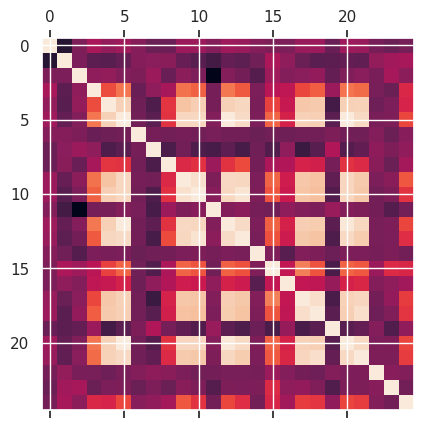

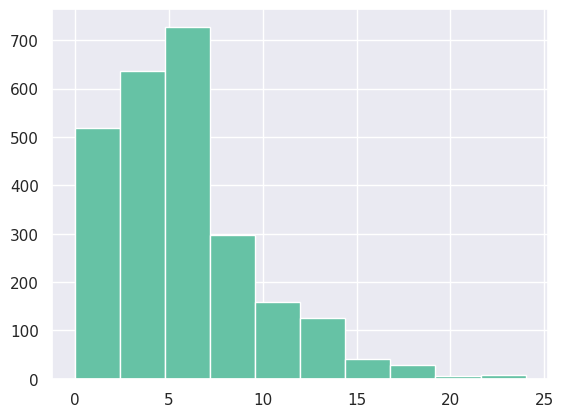

tourney_name             0
surface                  0
tourney_date             0
best_of                  0
minutes                  0
tot_games                0
round                    0
win                      0
df                       0
firstWon                 0
firstIn                  0
rank                     0
serve_games              0
serve_points             0
opponent                 0
opponent_ace             0
opponent_df              0
opponent_firstWon        0
opponent_firstIn         0
opponent_rank            0
opponent_serve_games     0
opponent_serve_points    0
opponent_hand            0
opponent_height          0
ace                      0
dtype: int64
---------------------
tourney_name             0
surface                  0
tourney_date             0
best_of                  0
minutes                  0
tot_games                0
round                    0
win                      0
df                       0
firstWon                 0
firstIn             

In [307]:
columns_titles = ["tourney_name", "surface", "tourney_date", "best_of", "minutes", "tot_games", "round", \
                        "win", "df", "firstWon", "firstIn", "rank", "serve_games", "serve_points", \
                        "opponent", "opponent_ace", "opponent_df", "opponent_firstWon", "opponent_firstIn", "opponent_rank", \
                        "opponent_serve_games", "opponent_serve_points", "opponent_hand", "opponent_height", "ace"]
data=data.reindex(columns=columns_titles)
#data=data.drop(data[data["opponent_rank"] == 0].index)
plt.matshow(data.corr())
plt.show()
plt.hist(data["ace"])
plt.show()
#plt.plot(data["round"], data[""], '.')
plt.show()
print(data.isnull().sum())
print("---------------------")
print(data.isna().sum())
print(data.head(5))
print(min(data["ace"]), max(data["ace"]))

In [308]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y_df = y.to_frame()
y = scaler.fit_transform(y_df)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=10)

# Create a svm model
from sklearn import svm
svm_model = svm.SVR(kernel='poly', max_iter=int(1e6))
svm_model.fit(x_train, y_train.ravel())

# MODEL
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(x_train, y_train.ravel())

LinearRegression()

In [309]:
from sklearn.metrics import mean_squared_error
print("----------- Training scores ------------")
# Support Vector Machine
y_pred = svm_model.predict(x_train)
for a,b in zip(y_pred, y_train):
    print(a,b)
err = mean_squared_error(y_train, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = linreg_model.predict(x_train)
for a,b in zip(y_pred, y_train):
    print(a,b)
err = mean_squared_error(y_train, y_pred)
print("Logistic")
print(err)

print()

print("------------ Test scores ---------------")
# Support Vector Machine
y_pred = svm_model.predict(x_test)
for a,b in zip(y_pred, y_test):
    print(a,b)
err = mean_squared_error(y_test, y_pred)
print("SVM")
print(err)
# Logistic Regression
y_pred = linreg_model.predict(x_test)
for a,b in zip(y_pred, y_test):
    print(a,b)
err = mean_squared_error(y_test, y_pred)
print("Logistic")
print(err)

----------- Training scores ------------
0.16889669071467744 [0.33333333]
0.11998969179085145 [0.08333333]
0.19869210979439061 [0.16666667]
0.29712030632642233 [0.375]
0.24987263061176251 [0.33333333]
0.08705978637102857 [0.125]
0.19170543174822258 [0.29166667]
0.17337534739778154 [0.16666667]
0.2511261907757028 [0.29166667]
0.1379851138088693 [0.08333333]
0.21560461697220729 [0.125]
0.2440180593631432 [0.33333333]
0.6115390806108401 [0.83333333]
0.24524127820166158 [0.125]
0.163936957317447 [0.20833333]
0.1672219177510222 [0.08333333]
0.24443091228018404 [0.20833333]
0.18303789350495664 [0.08333333]
0.17857817207793297 [0.125]
0.15808307271764904 [0.25]
0.1842456329614855 [0.08333333]
0.22489964996863848 [0.125]
0.3079146334396519 [0.20833333]
0.16954207066769095 [0.20833333]
0.3649500385187004 [0.33333333]
0.17686942865045624 [0.08333333]
0.09781180711601217 [0.04166667]
0.10030865670018346 [0.]
0.46963375862571405 [0.625]
0.1662393088139183 [0.04166667]
0.12786812013588184 [0.041666